In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import Image
import zipfile as zf
import matplotlib.image as img 
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB4
import random
from sklearn.metrics import confusion_matrix

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)
# For working on GPUs from "TensorFlow Determinism"
os.environ["TF_DETERMINISTIC_OPS"] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
new_path='/content/drive/MyDrive/AIMIA_Project'

In [ ]:
train_dir = os.path.join(new_path, 'train')
validation_dir = os.path.join(new_path, 'val')
test_dir = os.path.join(new_path, 'test')

BATCH_SIZE = 32
IMG_SIZE = (256, 256)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            label_mode="categorical",
                                                            seed = 1,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 label_mode="categorical",
                                                                 seed = 1,
                                                                 image_size=IMG_SIZE)
test_dataset = test_datagen.flow_from_directory(test_dir,
                                                shuffle=False,
                                                batch_size=BATCH_SIZE,
                                                class_mode="categorical",
                                                seed = 1,
                                                target_size=IMG_SIZE)


NameError: ignored

In [ ]:
class mymodelB4(EfficientNetB4):
  
  def __init__(self,include_top,weights,input_shape,pooling,fine_tune_at):
    


In [ ]:
model = tf.keras.Sequential()
effnetb4 = EfficientNetB4(include_top=False,weights='imagenet',input_shape=(256,256,3),pooling='max')
fine_tune_at = 427
# effnetb4.trainable = False
# Freeze all the layers before the `fine_tune_at` layer
for layer in effnetb4.layers[:fine_tune_at]:
  layer.trainable = False
model.add(effnetb4)
model.add(tf.keras.layers.Dense(3,activation='softmax'))
model.summary()
len(effnetb4.layers)

71686520/71686520 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 1792)             17673823  
                                                                 
 dense (Dense)               (None, 3)                 5379      
                                                                 
Total params: 17,679,202
Trainable params: 6,441,115
Non-trainable params: 11,238,087
_________________________________________________________________


476

In [ ]:
optimizer = tf.keras.optimizers.Adam(name='Adam')
ACCURACY_THRESHOLD = 0.98
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True
            
callbacks = myCallback()
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x=train_dataset,epochs=40,validation_data=validation_dataset,shuffle=False,callbacks=callbacks)

Epoch 1/40
77/77 [==============================] - 45s 408ms/step - loss: 0.9180 - accuracy: 0.8131 - val_loss: 0.8910 - val_accuracy: 0.8000
Epoch 2/40
77/77 [==============================] - 30s 365ms/step - loss: 0.1565 - accuracy: 0.9490 - val_loss: 0.4738 - val_accuracy: 0.8656
Epoch 3/40
77/77 [==============================] - 31s 369ms/step - loss: 0.0702 - accuracy: 0.9718 - val_loss: 0.2897 - val_accuracy: 0.9279
Epoch 4/40
77/77 [==============================] - 30s 365ms/step - loss: 0.0713 - accuracy: 0.9751 - val_loss: 0.3921 - val_accuracy: 0.9082
Epoch 5/40
77/77 [==============================] - 30s 362ms/step - loss: 0.0756 - accuracy: 0.9747 - val_loss: 0.4543 - val_accuracy: 0.9180
Epoch 6/40
77/77 [==============================] - 31s 370ms/step - loss: 0.0661 - accuracy: 0.9776 - val_loss: 0.2309 - val_accuracy: 0.9410
Epoch 7/40
77/77 [==============================] - ETA: 0s - loss: 0.0634 - accuracy: 0.9812
Reached 98.00% accuracy, so stopping training!!


In [ ]:
Y_pred_test = model.predict(test_dataset)

10/10 [==============================] - 7s 447ms/step


In [ ]:
y_pred_test = np.array([np.argmax(i)+1 for i in Y_pred_test])
Y_test_true = test_dataset.labels
y_true_test = np.array([i+1 for i in Y_test_true])

In [ ]:
from sklearn.metrics import classification_report
print('Classification Report')
target_names = ['meningioma', 'glioma', 'pituitary tumor']
print(classification_report(y_true_test, y_pred_test, target_names=target_names))

Classification Report
                 precision    recall  f1-score   support

     meningioma       0.93      0.96      0.95        72
         glioma       0.99      0.97      0.98       144
pituitary tumor       0.98      0.99      0.98        93

       accuracy                           0.97       309
      macro avg       0.97      0.97      0.97       309
   weighted avg       0.97      0.97      0.97       309



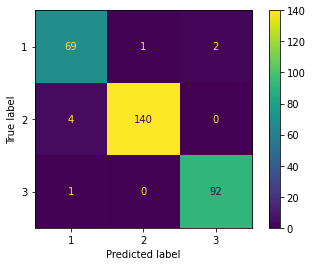

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true_test, y_pred_test)
plt.show()

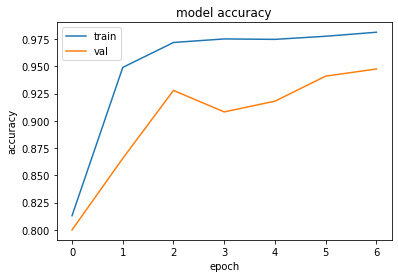

In [ ]:
# plotting the train and validation accuracy with no of epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

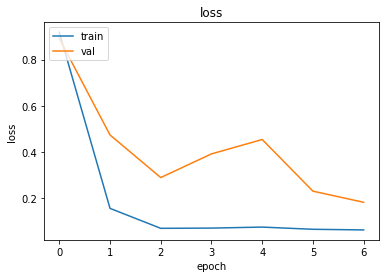

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('eefnetb4')

In [ ]:
# !apt-get install texlive texlive-xetex texlive-latex-extra pandoc
# !pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/AIMIA_project_B4.ipynb" ./
!jupyter nbconvert --to PDF "AIMIA_project_B4.ipynb"

[NbConvertApp] Converting notebook AIMIA_project_B4.ipynb to PDF
[NbConvertApp] Support files will be in AIMIA_project_B4_files/
[NbConvertApp] Making directory ./AIMIA_project_B4_files
[NbConvertApp] Making directory ./AIMIA_project_B4_files
[NbConvertApp] Making directory ./AIMIA_project_B4_files
[NbConvertApp] Writing 43402 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 75355 bytes to AIMIA_project_B4.pdf
